# Purpose of Notebook

The goal of this code is to investigate deep mixing with Red Giants.
- The mass used will be generated using a Random Forest Model

The steps that will need to be taken in order to investigate deep mixing
1.  Compute Carbon to Nitrogen Ratio for Red Giants $$ \Big[\frac{C}{N}\Big] = \Big[\frac{C}{Fe}\Big] - \Big[\frac{N}{Fe}\Big] $$
2.  Determine which stars are Red Giants
    - To achieve this, we will need to graph `log(g)` vs `teff` to create a HR diagram
    - Using the HR diagram, we will then determine the Red Giants

3.  Separate Stars into _**need help with this**_

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
apogee = pd.read_csv("ProcessedData/apogee_with_mass.csv")

# 1. Compute Relative Abundance of Carbon to Nitrogen

In [14]:
apogee.columns
apogee["c_n"] = apogee.c_fe - apogee.n_fe

In [15]:
apogee.c_n

0        -0.766240
1        -0.109907
2        -0.312257
3        -0.526230
4        -0.133700
            ...   
401083   -0.057909
401084   -0.188439
401085   -0.344606
401086   -0.262194
401087   -0.220958
Name: c_n, Length: 401088, dtype: float64

# 2. Find the !(Blue Midgets)

Text(0.5, 1.0, 'Surface Gravity vs Effective Temperature')

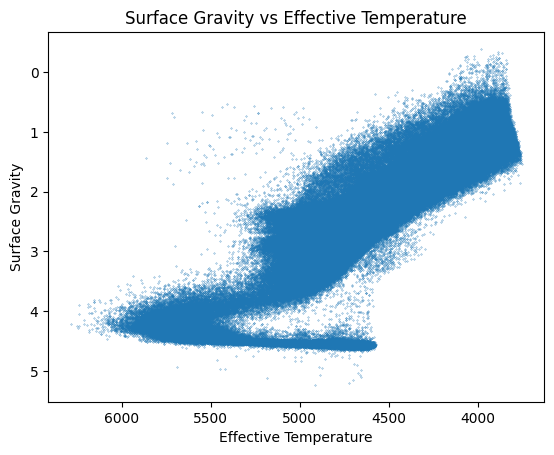

In [53]:
figure = plt.plot(
    apogee.teff,
    apogee.logg,
    '.',
    markersize=0.5,
)

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.xlabel("Effective Temperature")
plt.ylabel("Surface Gravity")
plt.title("Surface Gravity vs Effective Temperature")

Text(0.5, 1.0, 'Surface Gravity vs Log Effective Temperature')

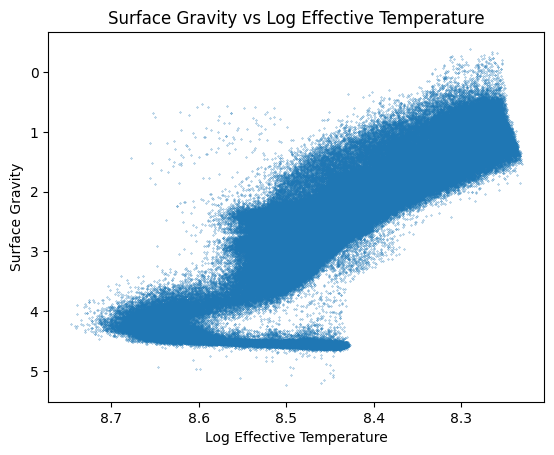

In [60]:
figure = plt.plot(
    np.log(apogee.teff),
    apogee.logg,
    '.',
    markersize=0.5,
)

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.xlabel("Log Effective Temperature")
plt.ylabel("Surface Gravity")
plt.title("Surface Gravity vs Log Effective Temperature")

I HAVE NO IDEA WHAT TO DO WITH THIS LOL

# 3. ??????? Not sure yet

TALK ABOUT FIRST DREDGE UP HEAR

Separate Data into 25 Groups, which is determined by the metallicity and mass.
- Separate Mass like so:
$$ 0.5 \leq \frac{M}{M_\odot} < 1 , 1 \leq \frac{M}{M_\odot} < 1.25,  1.25 \leq \frac{M}{M_\odot} < 1.50, 1.50 \leq \frac{M}{M_\odot} < 2.2 ,\frac{M}{M_\odot} \geq 2.2 $$

- Separate Metallicity like so:
$$ 0.25 \geq \Big[\frac{Fe}{H}\Big] > -0.25$, -0.25 \geq \Big[\frac{Fe}{H}\Big] > -0.75$, -0.75 \geq \Big[\frac{Fe}{H}\Big] > -1.25$, -1.25 \geq \Big[\frac{Fe}{H}\Big] > -1.75$, -1.75 \geq \Big[\frac{Fe}{H}\Big] > -2.50 $$


In [35]:
fe_h_range = [0.25, -0.25, -0.75, -1.25, -1.75, -2.5]
mass_range = [0.5, 1, 1.25, 1.5, 2.2, 4.0]

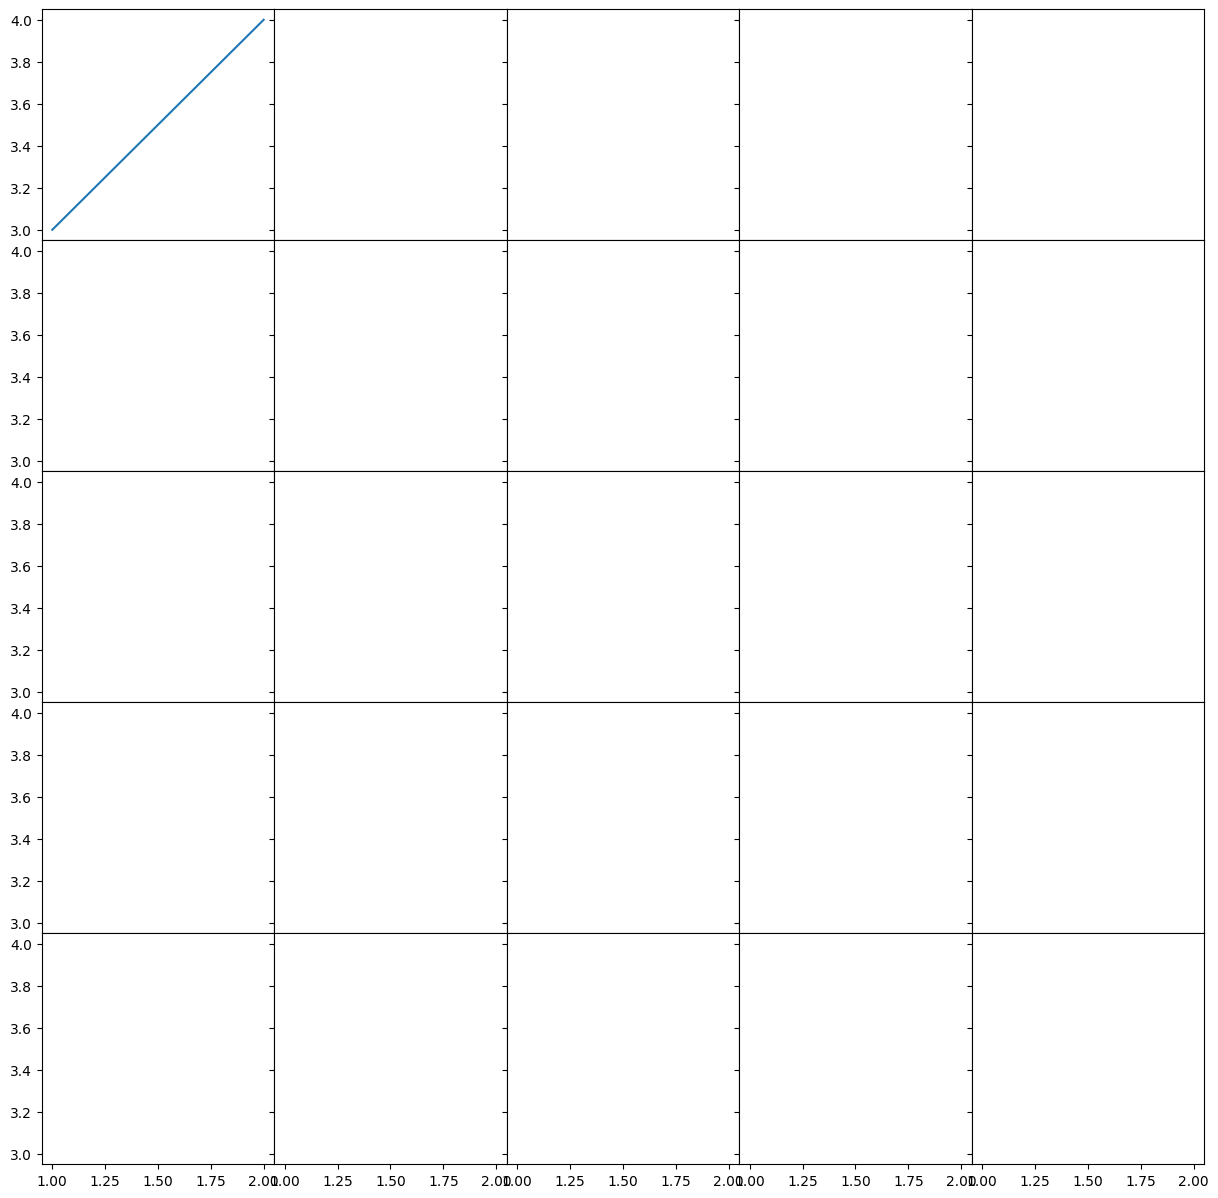

In [39]:
figure, axis = plt.subplots(
    nrows=5,
    ncols=5,
    figsize=(15, 15),
    sharex=True,
    sharey=True
)

axis[0, 0].plot([1, 2], [3, 4])

figure.subplots_adjust(hspace=0)
figure.subplots_adjust(wspace=0)

# Populate each part of the graph
for i in range(5):
    for j in range(5):
        k = 0
        # axis[i, j].xaxis.set_visible(False)
        # axis[i, j].yaxis.set_visible(False)
        # TODO: MAKE A FUNCTION THAT POPULATES THE TABLE